In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load the data
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

##DATA PRE-PROCESSING

In [ ]:
# Preprocessing the text data
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Remove stopwords
    stopwords_set = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word.lower() not in stopwords_set])

    # Remove special characters and numbers
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)

    # Convert text to lowercase
    text = text.lower()

    return text

In [ ]:
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


<Axes: xlabel='target', ylabel='count'>

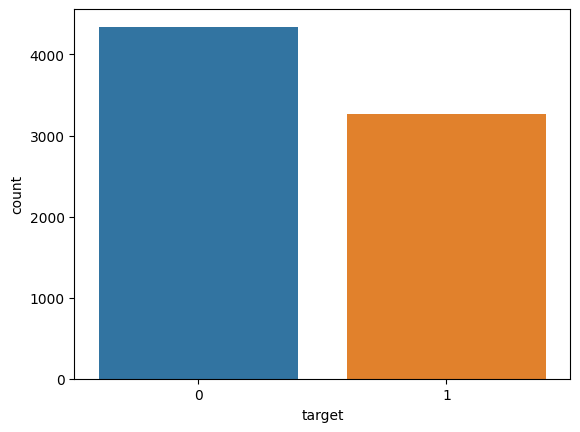

In [ ]:
import seaborn as sns

sns.countplot(data=train_data, x='target')

In [ ]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
vocab_size = len(tokenizer.word_index) + 1

train_sequences = tokenizer.texts_to_sequences(train_data['text'])
train_padded = pad_sequences(train_sequences)


##MODEL-1

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 100, input_length=train_padded.shape[1]))
model1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
results = model1.fit(train_padded, train_data['target'], epochs=10, batch_size=50,validation_split=0.2)

Epoch 1/10
122/122 [==============================] - 21s 136ms/step - loss: 0.5627 - accuracy: 0.7030 - val_loss: 0.4707 - val_accuracy: 0.7866
Epoch 2/10
122/122 [==============================] - 19s 158ms/step - loss: 0.2982 - accuracy: 0.8801 - val_loss: 0.4858 - val_accuracy: 0.7886
Epoch 3/10
122/122 [==============================] - 19s 159ms/step - loss: 0.1697 - accuracy: 0.9389 - val_loss: 0.5561 - val_accuracy: 0.7557
Epoch 4/10
122/122 [==============================] - 14s 116ms/step - loss: 0.1069 - accuracy: 0.9654 - val_loss: 0.6074 - val_accuracy: 0.7571
Epoch 5/10
122/122 [==============================] - 14s 117ms/step - loss: 0.0853 - accuracy: 0.9698 - val_loss: 0.7999 - val_accuracy: 0.7544
Epoch 6/10
122/122 [==============================] - 14s 116ms/step - loss: 0.0724 - accuracy: 0.9734 - val_loss: 0.7500 - val_accuracy: 0.7420
Epoch 7/10
122/122 [==============================] - 15s 121ms/step - loss: 0.0559 - accuracy: 0.9782 - val_loss: 0.7809 - val_ac

In [ ]:
# Tokenization and padding for test data
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_padded = pad_sequences(test_sequences, maxlen=train_padded.shape[1])  # Use the same maxlen as the training data

# Make predictions
predictions1 = model1.predict(test_padded)
predictions1 = (predictions1 > 0.5).astype(int)

102/102 [==============================] - 4s 34ms/step


In [ ]:
import pandas as pd

# Create a DataFrame for predictions
submission_data = pd.DataFrame({'id': test_data['id'], 'target': predictions1.flatten()})

# Save the DataFrame to a CSV file
submission_data.to_csv('submission3.csv', index=False)

##MODEL-2

In [ ]:
import tensorflow as tf

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
#creating a sequential model
model2 = tf.keras.Sequential()

#adding input layer with shape of padded seq
model2.add(tf.keras.layers.Input(shape=train_padded.shape[1]))

#embedding layer with input as vocab size, output dim as 100
model2.add(tf.keras.layers.Embedding(vocab_size,100, input_length = train_padded.shape[1]))

#3 LSTM layer with 128 units and dropout layers to prevent overfitting
model2.add(tf.keras.layers.LSTM(128, return_sequences=True))
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.LSTM(128,return_sequences=True))
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.LSTM(128))
model2.add(tf.keras.layers.Dropout(0.5))

# dense layer with 256 units
model2.add(tf.keras.layers.Dense(256))
model2.add(tf.keras.layers.Dropout(0.2))

# dense layer with 1 unit and sigmoid activation for binary classification
model2.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#model summary
print(model2.summary())

# compiling with binary cross-entropy loss and adam optimizer
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 100)           1688000   
                                                                 
 lstm_1 (LSTM)               (None, 23, 128)           117248    
                                                                 
 dropout (Dropout)           (None, 23, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 23, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 23, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [ ]:
history = model2.fit(train_padded, train_data['target'], epochs=20, batch_size=128)

Epoch 1/20
60/60 [==============================] - 27s 304ms/step - loss: 0.6070 - accuracy: 0.6619
Epoch 2/20
60/60 [==============================] - 19s 322ms/step - loss: 0.3308 - accuracy: 0.8638
Epoch 3/20
60/60 [==============================] - 18s 301ms/step - loss: 0.1813 - accuracy: 0.9342
Epoch 4/20
60/60 [==============================] - 19s 323ms/step - loss: 0.1159 - accuracy: 0.9597
Epoch 5/20
60/60 [==============================] - 18s 301ms/step - loss: 0.0970 - accuracy: 0.9664
Epoch 6/20
60/60 [==============================] - 18s 302ms/step - loss: 0.0820 - accuracy: 0.9708
Epoch 7/20
60/60 [==============================] - 19s 318ms/step - loss: 0.0662 - accuracy: 0.9757
Epoch 8/20
60/60 [==============================] - 20s 332ms/step - loss: 0.0675 - accuracy: 0.9757
Epoch 9/20
60/60 [==============================] - 19s 320ms/step - loss: 0.0611 - accuracy: 0.9781
Epoch 10/20
60/60 [==============================] - 18s 295ms/step - loss: 0.0532 - accura

In [ ]:
# Tokenization and padding for test data
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_padded = pad_sequences(test_sequences, maxlen=train_padded.shape[1])  # Use the same maxlen as the training data

# Make predictions
predictions2 = model2.predict(test_padded)
predictions2 = (predictions2 > 0.5).astype(int)

102/102 [==============================] - 6s 45ms/step


In [ ]:
import pandas as pd

# Create a DataFrame for predictions
submission_data = pd.DataFrame({'id': test_data['id'], 'target': predictions2.flatten()})

# Save the DataFrame to a CSV file
submission_data.to_csv('submission_allika.csv', index=False)

##DATA VISUALISATIONS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

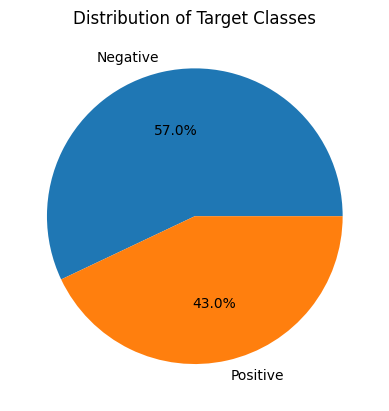

In [ ]:
# Pie Chart of Actual results from the training data
unique, counts = np.unique(train_data['target'], return_counts=True)
labels = ['Negative', 'Positive']
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Target Classes")
plt.show()

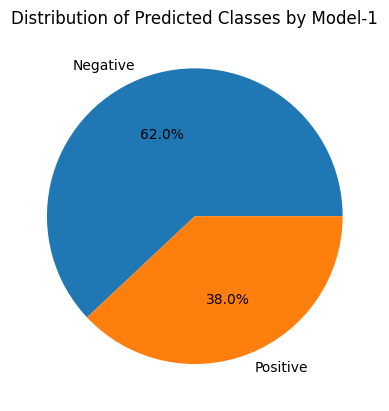

In [ ]:
# Pie Chart or Bar Plot of Predicted Classes
unique, counts = np.unique(predictions1, return_counts=True)
labels = ['Negative', 'Positive']
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Predicted Classes by Model-1")
plt.show()

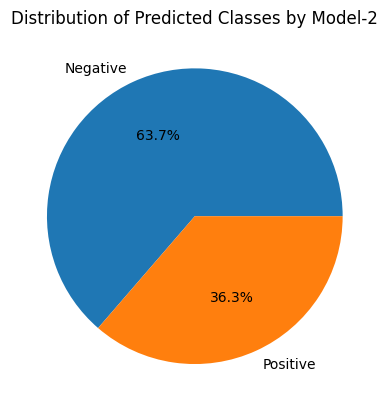

In [ ]:
# Pie Chart or Bar Plot of Predicted Classes
unique, counts = np.unique(predictions2, return_counts=True)
labels = ['Negative', 'Positive']
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Predicted Classes by Model-2")
plt.show()

Text(0, 0.5, 'Rates')

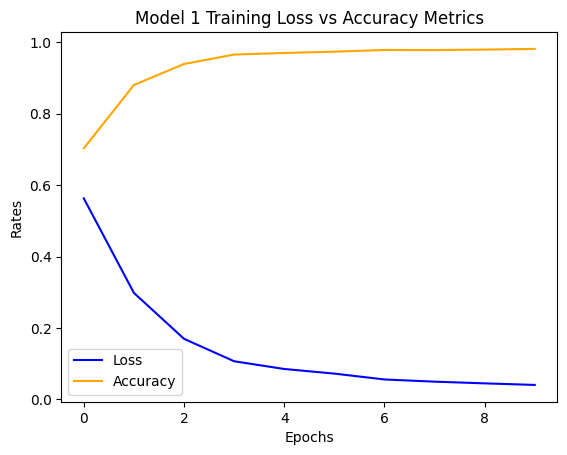

In [ ]:
import seaborn as sns
sns.lineplot(data=results.history['loss'], label='Loss', color= 'blue')
lplot = sns.lineplot(data=results.history['accuracy'], label='Accuracy', color= 'orange')
lplot.set_title('Model 1 Training Loss vs Accuracy Metrics')
lplot.set_xlabel('Epochs')
lplot.set_ylabel('Rates')

Text(0, 0.5, 'Rates')

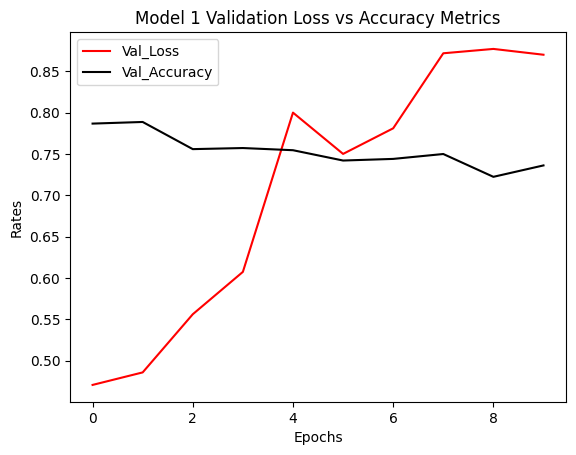

In [ ]:
import seaborn as sns
sns.lineplot(data=results.history['val_loss'], label='Val_Loss', color= 'red')
lplot = sns.lineplot(data=results.history['val_accuracy'], label='Val_Accuracy', color= 'black')
lplot.set_title('Model 1 Validation Loss vs Accuracy Metrics')
lplot.set_xlabel('Epochs')
lplot.set_ylabel('Rates')